## Cunningham and Yuter convective organization test over a 3 hour scene

This notebook tests the Cunningham and Yuter classification over one chosen 3 hour scene.

In [130]:
import pyart
from numba import jit
%matplotlib inline
import xarray

Load the radar file.

In [127]:
cpol_path = '/home/rjackson/data/radar/gridded_data/CPOL_20051224_1400_GRIDS_2500m.nc'
grid_cpol = pyart.io.read_grid(cpol_path)
print(grid_cpol.fields.keys())

dict_keys(['velocity', 'longitude', 'temperature', 'ROI', 'latitude', 'radar_echo_classification', 'total_power', 'giangrande_specific_differential_phase', 'reflectivity', 'NW', 'giangrande_differential_phase', 'radar_estimated_rain_rate', 'corrected_differential_reflectivity', 'region_dealias_velocity', 'velocity_texture', 'D0', 'cross_correlation_ratio'])


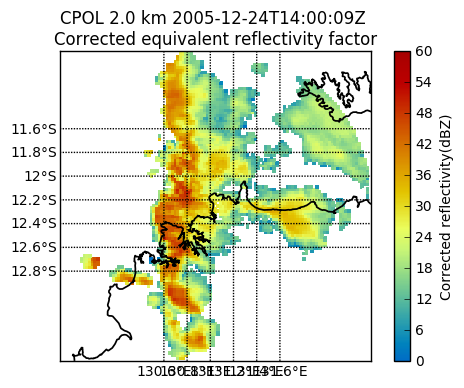

In [128]:
display = pyart.graph.GridMapDisplay(grid_cpol)
display.plot_basemap(resolution='h', lat_lines=[-12.8, -12.6, -12.4, -12.2, -12.0, -11.8, -11.6],
                     lon_lines=[130.6, 130.8, 131, 131.2, 131.4, 131.6])
display.plot_grid('reflectivity', level=4, cmap='pyart_HomeyerRainbow', vmin=0, vmax=60)

Test Steiner classification

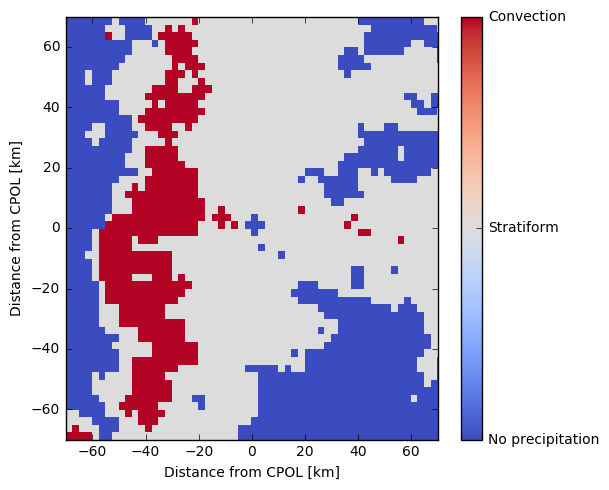

In [129]:
convective = pyart.retrieve.steiner_conv_strat(grid_cpol, area_relation='small', dx=1000.0, dy=1000.0)
#grid_cpol.add_field('conv_strat', convective)

plt.figure(figsize=(6,12))
plt.subplot(211)
x,y = np.meshgrid(grid_cpol.x['data'], grid_cpol.y['data'])
plt.pcolormesh(x/1e3,y/1e3,convective['data'], cmap='coolwarm')
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.xlim([-70,70])
plt.ylim([-70,70])
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['No precipitation', 'Stratiform', 'Convection'])

Regrid to 2 km, 5, 10, and 25 km and calculate %convective, stratiform per grid cell.

In [132]:
def get_conv_strat_percentage(convective, x, y, new_res, x_min=None, y_min=None, x_max=None, y_max=None):
    old_y, old_x = np.meshgrid(x, y)
    
    if(x_min == None):
        x_min = x.min()
    if(x_max == None):
        x_max = x.max()    
        
    # Figure our new boundaries from new given resolution
    x_bound_new = np.arange(x.min(), x.max()+new_res, new_res)
    y_bound_new = np.arange(y.min(), y.max()+new_res, new_res)
    y_new, x_new = np.meshgrid(x_bound_new, y_bound_new)
    strat_perc = np.zeros(x_new.shape)
    conv_perc = np.zeros(x_new.shape)
    for i in range(len(x_bound_new)-1):
        for j in range(len(y_bound_new)-1):
            grid_inds_strat = np.where(np.logical_and.reduce((
                        old_x >= x_new[i,j], old_x < x_new[i+1,j], old_y >= y_new[i,j], old_y < y_new[i,j+1],
                        convective == 1)))
            grid_inds_conv = np.where(np.logical_and.reduce((
                        old_x >= x_new[i,j], old_x < x_new[i+1,j], old_y >= y_new[i,j], old_y < y_new[i,j+1],
                        convective == 2)))
            grid_inds_tot = np.where(np.logical_and.reduce((
                        old_x >= x_new[i,j], old_x < x_new[i+1,j], old_y >= y_new[i,j], old_y < y_new[i,j+1])))
            num_strat = len(grid_inds_strat[0])
            num_conv = len(grid_inds_conv[0])
            num_tot = len(grid_inds_tot[0])
            if(num_tot > 0):
                strat_perc[i,j] = num_strat/num_tot*100
                conv_perc[i,j] = num_conv/num_tot*100
    
    return strat_perc.T, conv_perc.T, x_new, y_new

In [133]:
%%time
strat_perc_2km, conv_perc_2km, x_2km, y_2km = get_conv_strat_percentage(convective['data'], 
                                                                        grid_cpol.x['data'], grid_cpol.y['data'],
                                                                        2000.0, x_min=-70000.0, x_max=70000.0,
                                                                        y_min=-70000.0, y_max=70000.0)

CPU times: user 4.02 s, sys: 36 ms, total: 4.06 s
Wall time: 4.06 s


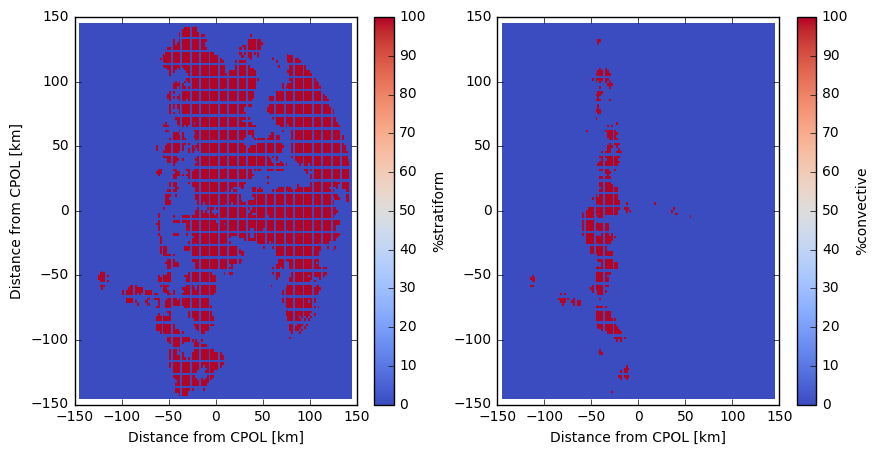

In [134]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.pcolormesh(x_2km/1e3,y_2km/1e3,strat_perc_2km, cmap='coolwarm')
cbar = plt.colorbar(label='%stratiform')
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.subplot(122)
plt.pcolormesh(x_2km/1e3,y_2km/1e3,conv_perc_2km, cmap='coolwarm')
cbar = plt.colorbar(label='%convective')
plt.xlabel('Distance from CPOL [km]')


In [136]:
strat_perc_5km, conv_perc_5km, x_5km, y_5km = get_conv_strat_percentage(convective['data'], 
                                                                        grid_cpol.x['data'], grid_cpol.y['data'],
                                                                        5000.0, x_min=-70000.0, x_max=70000.0,
                                                                        y_min=-70000.0, y_max=70000.0)
strat_perc_10km, conv_perc_10km, x_10km, y_10km = get_conv_strat_percentage(convective['data'], 
                                                                        grid_cpol.x['data'], grid_cpol.y['data'],
                                                                        10000.0, x_min=-70000.0, x_max=70000.0,
                                                                        y_min=-70000.0, y_max=70000.0)
strat_perc_25km, conv_perc_25km, x_25km, y_25km = get_conv_strat_percentage(convective['data'], 
                                                                            grid_cpol.x['data'], grid_cpol.y['data'],
                                                                            25000.0, x_min=-70000.0, x_max=70000.0,
                                                                            y_min=-70000.0, y_max=70000.0)

(-70, 70)

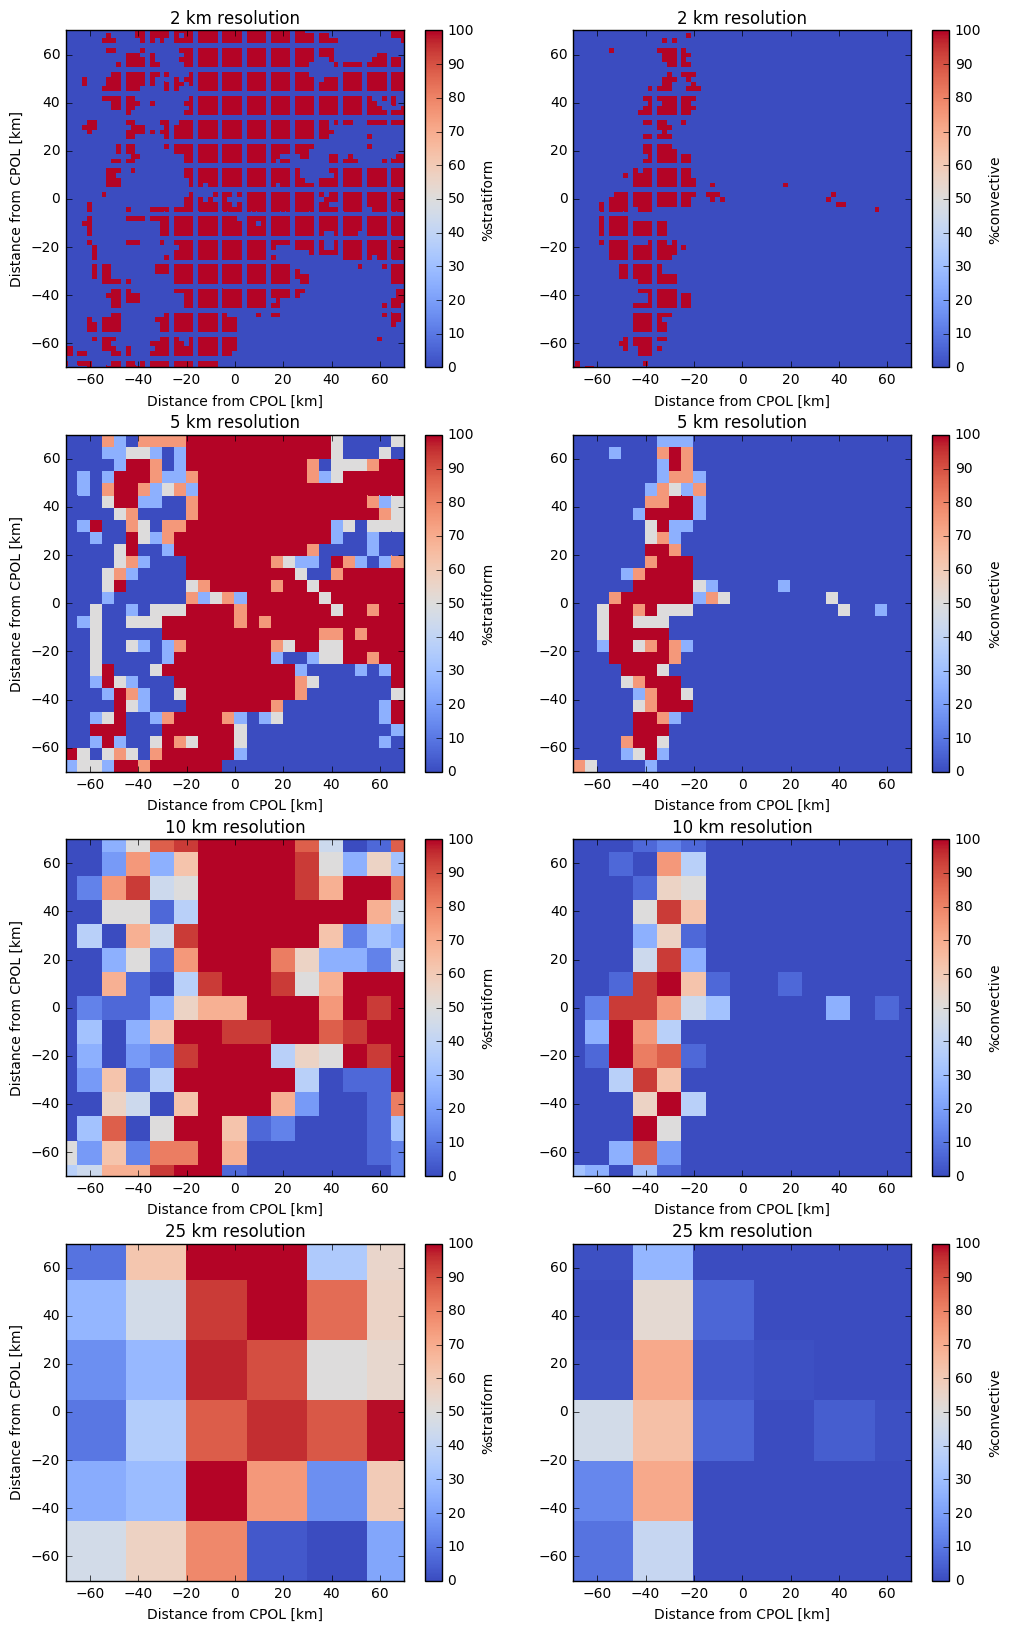

In [137]:
plt.figure(figsize=(12,20))
plt.subplot(421)
plt.pcolormesh(x_2km/1e3,y_2km/1e3,strat_perc_2km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%stratiform')
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.title('2 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])
plt.subplot(422)
plt.pcolormesh(x_2km/1e3,y_2km/1e3,conv_perc_2km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%convective')
plt.xlabel('Distance from CPOL [km]')
plt.title('2 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])
plt.subplot(423)
plt.pcolormesh(x_5km/1e3,y_5km/1e3,strat_perc_5km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%stratiform')
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.title('5 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])
plt.subplot(424)
plt.pcolormesh(x_5km/1e3,y_5km/1e3,conv_perc_5km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%convective')
plt.xlabel('Distance from CPOL [km]')
plt.title('5 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])
plt.subplot(425)
plt.pcolormesh(x_10km/1e3,y_10km/1e3,strat_perc_10km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%stratiform')
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.title('10 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])
plt.subplot(426)
plt.pcolormesh(x_10km/1e3,y_10km/1e3,conv_perc_10km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%convective')
plt.xlabel('Distance from CPOL [km]')
plt.title('10 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])
plt.subplot(427)
plt.pcolormesh(x_25km/1e3,y_25km/1e3,strat_perc_25km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%stratiform')
plt.xlabel('Distance from CPOL [km]')
plt.ylabel('Distance from CPOL [km]')
plt.title('25 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])
plt.subplot(428)
plt.pcolormesh(x_25km/1e3,y_25km/1e3,conv_perc_25km, cmap='coolwarm', vmin=0, vmax=100)
cbar = plt.colorbar(label='%convective')
plt.xlabel('Distance from CPOL [km]')
plt.title('25 km resolution')
plt.xlim([-70,70])
plt.ylim([-70,70])

In [ ]:
dataset_keys = {'pct_conv_original': (['y', 'x'], convective['data']),
                'pct_conv_original2': (['y2', 'x2'], convective['data']),
                'pct_conv_original5': (['y5', 'x5'], convective['data']),
                'pct_conv_original10': (['y10', 'x10'], convective['data'])
                'pct_conv_original25': (['y25', 'x25'], convective['data'])}
out_cdf = xarray.Dataset()